In [1]:
import numpy as np
from scipy.stats import multivariate_normal, invgamma, geninvgauss
import matplotlib.pyplot as plt

def bayesL_gibbs_sampler(X_f, X, y, num_iterations, 
                         a_e=2.0, b_e=2.0, 
                         theta=1.0, 
                         tau_f2=1e6):
    """
    BayesL Model Gibbs Sampler using scipy.stats.geninvgauss

    Parameters:
    X_f: Fixed effects design matrix (n x q)
    X: SNP effects design matrix (n x p)
    y: Response vector (n,)
    num_iterations: Number of iterations
    a_e, b_e: Hyperparameters for sigma_e^2 prior
    theta: Parameter for the exponential prior on lambda_j^2
    tau_f2: Prior variance for fixed effects coefficients

    Returns:
    beta_f_samples: Samples of fixed effects coefficients (num_iterations x q)
    beta_samples: Samples of SNP effects coefficients (num_iterations x p)
    lambda2_samples: Samples of SNP effect variances (num_iterations x p)
    sigma_e2_samples: Samples of residual variance (num_iterations,)
    """
    n, p = X.shape
    q = X_f.shape[1]
    
    # Initialize parameters
    beta_f = np.zeros(q)
    beta = np.zeros(p)
    lambda2 = np.ones(p)
    sigma_e2 = 1.0
    
    # Store samples
    beta_f_samples = np.zeros((num_iterations, q))
    beta_samples = np.zeros((num_iterations, p))
    lambda2_samples = np.zeros((num_iterations, p))
    sigma_e2_samples = np.zeros(num_iterations)
    
    # Precompute X_f^T X_f
    X_fTX_f = X_f.T @ X_f
    
    for t in range(num_iterations):
        # Step 1: Update beta_f
        Sigma_beta_f_inv = (X_fTX_f / sigma_e2) + (1 / tau_f2) * np.eye(q)
        Sigma_beta_f = np.linalg.inv(Sigma_beta_f_inv)
        mu_beta_f = Sigma_beta_f @ (X_f.T @ (y - X @ beta)) / sigma_e2
        beta_f = multivariate_normal.rvs(mean=mu_beta_f, cov=Sigma_beta_f)
        
        # Step 2: Update beta
        Lambda_inv = np.diag(1 / lambda2)
        Sigma_beta_inv = (X.T @ X) / sigma_e2 + Lambda_inv
        Sigma_beta = np.linalg.inv(Sigma_beta_inv)
        mu_beta = Sigma_beta @ (X.T @ (y - X_f @ beta_f)) / sigma_e2
        beta = multivariate_normal.rvs(mean=mu_beta, cov=Sigma_beta)
        
        # Step 3: Update lambda_j^2
        for j in range(p):
            lambda_param = 0.5  # λ = 0.5
            beta_j_sq = beta[j] ** 2
            sigma_e2_val = sigma_e2

            if beta_j_sq != 0:
                chi = theta  # χ = θ
                psi = beta_j_sq / sigma_e2_val  # ψ = β_j^2 / σ_e^2

                # Compute b and scale parameters
                b_param = np.sqrt(chi * psi)
                scale_param = np.sqrt(psi / chi)

                # Sample from GIG distribution
                lambda2_j = geninvgauss.rvs(lambda_param, b_param, scale=scale_param)
                lambda2[j] = lambda2_j
            else:
                lambda2[j] = np.inf  # Assign a large number or handle appropriately
        
        # Step 4: Update sigma_e^2
        residual = y - X_f @ beta_f - X @ beta
        shape_e = a_e + n / 2
        scale_e = b_e + 0.5 * (residual.T @ residual)
        sigma_e2 = invgamma.rvs(a=shape_e, scale=scale_e)
        
        # Store samples
        beta_f_samples[t, :] = beta_f
        beta_samples[t, :] = beta
        lambda2_samples[t, :] = lambda2
        sigma_e2_samples[t] = sigma_e2
        
        # Optional: print progress
        if (t+1) % 1000 == 0 or t == 0:
            print(f"Iteration {t+1}/{num_iterations} completed.")
    
    return beta_f_samples, beta_samples, lambda2_samples, sigma_e2_samples


In [2]:
def simulate_data(n_samples, n_fixed_effects, n_snps, true_pi=0.5, true_sigma_e2=1.0):
    # 固定效应的设计矩阵 X_f 和 SNP 标记的设计矩阵 X
    X_f = np.random.randn(n_samples, n_fixed_effects)
    X = np.random.randn(n_samples, n_snps)
    
    # 真实的固定效应参数和 SNP 效应参数
    true_beta_f = np.random.randn(n_fixed_effects)
    true_beta = np.random.randn(n_snps) * np.random.binomial(1, true_pi, size=n_snps)  # 稀疏性
    
    # 残差噪声
    epsilon = np.random.randn(n_samples) * np.sqrt(true_sigma_e2)
    
    # 生成表型 y
    y = X_f @ true_beta_f + X @ true_beta + epsilon
    
    return X_f, X, y, true_beta_f, true_beta


In [3]:
# 模拟数据
n_samples = 500
n_fixed_effects = 2
n_snps = 50
X_f, X, y, true_beta_f, true_beta = simulate_data(n_samples, n_fixed_effects, n_snps, true_pi=0.5)
# Check true beta values for the first few SNPs and the fixed effects
true_beta[:10], true_beta_f

(array([-0.10599704,  0.        , -0.79450653,  0.        , -0.4931865 ,
        -0.        ,  0.        ,  0.26972029,  0.        ,  0.        ]),
 array([-0.62236578,  0.29346579]))

In [4]:

# 设置参数
num_iterations = 10000
a_e, b_e = 2.0, 2.0
theta = 1.0
tau_f2 = 1e6

beta_f_samples, beta_samples, lambda2_samples, sigma_e2_samples = bayesL_gibbs_sampler(X_f, X, y, num_iterations, a_e, b_e, theta, tau_f2)

# 比较真实参数和估计参数
estimated_beta_f = np.mean(beta_f_samples, axis=0)
estimated_beta = np.mean(beta_samples, axis=0)

print("真实的固定效应参数: ", true_beta_f)
print("估计的固定效应参数: ", estimated_beta_f)

print("\n真实的SNP效应参数(前10个): ", true_beta[:10])
print("估计的SNP效应参数(前10个): ", estimated_beta[:10])


Iteration 1/10000 completed.
Iteration 1000/10000 completed.
Iteration 2000/10000 completed.
Iteration 3000/10000 completed.
Iteration 4000/10000 completed.
Iteration 5000/10000 completed.
Iteration 6000/10000 completed.
Iteration 7000/10000 completed.
Iteration 8000/10000 completed.
Iteration 9000/10000 completed.
Iteration 10000/10000 completed.
真实的固定效应参数:  [-0.62236578  0.29346579]
估计的固定效应参数:  [-0.56043889  0.29023068]

真实的SNP效应参数(前10个):  [-0.10599704  0.         -0.79450653  0.         -0.4931865  -0.
  0.          0.26972029  0.          0.        ]
估计的SNP效应参数(前10个):  [-1.31297071e-01 -5.98110553e-03 -8.42437869e-01 -4.76498763e-04
 -5.10405672e-01  4.72163490e-03 -4.11521028e-02  2.44100293e-01
  4.65632130e-02  5.12967576e-02]


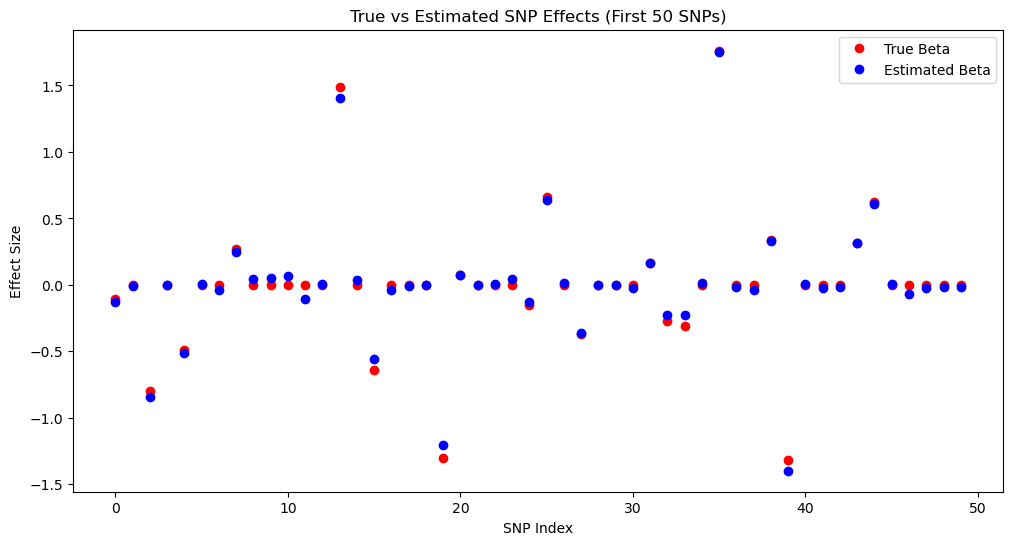

In [5]:
# 绘制真实和估计的 SNP 效应参数对比
plt.figure(figsize=(12, 6))
plt.plot(true_beta, 'ro', label="True Beta")
plt.plot(estimated_beta, 'bo', label="Estimated Beta")
plt.legend()
plt.xlabel("SNP Index")
plt.ylabel("Effect Size")
plt.title("True vs Estimated SNP Effects (First 50 SNPs)")
plt.show()


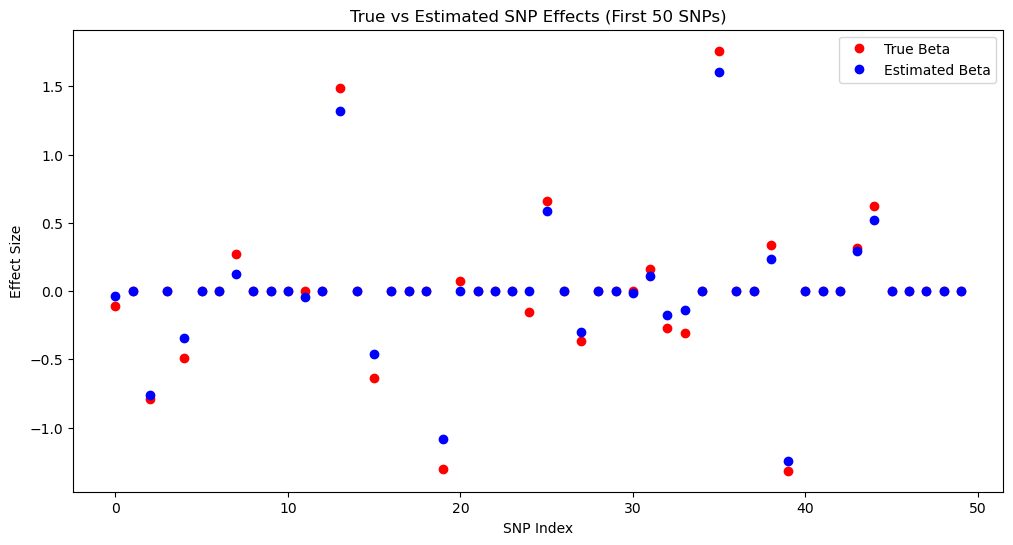

In [6]:
# 利用一般的lasso回归构建模型
from sklearn.linear_model import Lasso

# Apply Lasso regression from sklearn
lasso_model = Lasso(alpha=0.1, max_iter=10000)  # Using L1 regularization
lasso_model.fit(X[:, :n_snps], y)

# Estimate beta coefficients from Lasso
estimated_beta_lasso = lasso_model.coef_

# Compare the true and estimated beta for the first 10 SNPs
# true_beta[:10], estimated_beta_lasso[:10]
plt.figure(figsize=(12, 6))
plt.plot(true_beta, 'ro', label="True Beta")
plt.plot(estimated_beta_lasso, 'bo', label="Estimated Beta")
plt.legend()
plt.xlabel("SNP Index")
plt.ylabel("Effect Size")
plt.title("True vs Estimated SNP Effects (First 50 SNPs)")
plt.show()